<a href="https://colab.research.google.com/github/santoshkumarbvp/Computer-Vision/blob/main/transfer%20learning/MNIST_fashion_VGG16_kerastuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q -U keras-tuner


     |████████████████████████████████| 71kB 5.6MB/s 


In [45]:
import kerastuner as kt
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
!nvidia-smi

Fri Jan  8 13:01:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## The Data

**TASK 1: Run the code below to download the dataset using Keras.**

In [7]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## Visualizing the Data

**TASK 2: Use matplotlib to view an image from the data set. It can be any image from the data set.**

In [8]:
x_train[0].shape, x_train.shape

((28, 28), (60000, 28, 28))

In [9]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

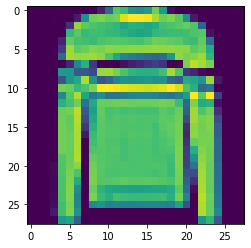

In [10]:
plt.imshow(x_train[5])

## Preprocessing the Data

**TASK 3: Normalize the X train and X test data by dividing by the max value of the image arrays.**

In [11]:
x_train=x_train/255
x_test=x_test/255

**Task 4: Reshape the X arrays to include a 4 dimension of the single channel. Similar to what we did for the numbers MNIST data set.**

In [12]:
x_test.shape, x_train.shape

((10000, 28, 28), (60000, 28, 28))

In [13]:
import numpy as np

In [14]:
x_test=np.expand_dims(x_test, axis=-1)
x_train=np.expand_dims(x_train, axis=-1)

**TASK 5: Convert the y_train and y_test values to be one-hot encoded for categorical analysis by Keras.**

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
y_test_ohe = to_categorical(y_test)
y_train_ohe = to_categorical(y_train)

## Building the Model

**TASK 5: Use Keras to create a model consisting of at least the following layers (but feel free to experiment):**

* 2D Convolutional Layer, filters=32 and kernel_size=(4,4)
* Pooling Layer where pool_size = (2,2)

* Flatten Layer
* Dense Layer (128 Neurons, but feel free to play around with this value), RELU activation

* Final Dense Layer of 10 Neurons with a softmax activation

**Then compile the model with these parameters: loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [21]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(kernel_size=(4,4),filters=32,input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())

  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(Dense(units=hp_units,activation='relu'))
  
  model.add(Dense(units=10,activation='softmax'))
  
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),metrics=['accuracy'])
  return model

In [22]:
tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [ ]:
es = EarlyStopping(monitor='accuracy',patience=3)

In [24]:
tuner.search(x_train, y_train_ohe, epochs = 10, validation_data = (x_test, y_test_ohe))


Trial 30 Complete [00h 00m 45s]
val_accuracy: 0.8704000115394592

Best val_accuracy So Far: 0.9103000164031982
Total elapsed time: 00h 09m 35s
INFO:tensorflow:Oracle triggered exit


In [25]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]


In [29]:
best_hps.get('units'),best_hps.get('learning_rate')

(224, 0.001)

# retrain with new parameter after keras-tuner

In [38]:
# need to retrain with optimum parameters , we get from keras-tuner. In this case , we have (224,0.001) as best parameter

In [39]:
model = Sequential()
model.add(Conv2D(kernel_size=(4,4),filters=32,input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(units=224,activation='relu'))
  
model.add(Dense(units=10,activation='softmax'))
  
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate = 0.001),metrics=['accuracy'])


In [40]:
model.fit(x_train,y_train_ohe,validation_data=(x_test,y_test_ohe), epochs=20)

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5124 - accuracy: 0.8201 - val_loss: 0.3421 - val_accuracy: 0.8679
Epoch 2/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2723 - accuracy: 0.8993 - val_loss: 0.2966 - val_accuracy: 0.8904
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2031 - accuracy: 0.9254 - val_loss: 0.2746 - val_accuracy: 0.9034
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1641 - accuracy: 0.9400 - val_loss: 0.2778 - val_accuracy: 0.9049
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1296 - accuracy: 0.9513 - val_loss: 0.2810 - val_accuracy: 0.9081
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1073 - accuracy: 0.9615 - val_loss: 0.2854 - val_accuracy: 0.9139
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0876 - accuracy: 0.9671 - val_loss: 0.3309 - val_accuracy:

In [41]:
pred = model.predict(x_test)

In [42]:
pred.shape

(10000, 10)

In [44]:
pred_i= np.array([np.argmax(i) for i in pred])

In [46]:
confusion_matrix(y_test, pred_i)

array([[884,   2,  12,  16,   4,   0,  79,   0,   3,   0],
       [  1, 975,   0,  17,   3,   0,   1,   0,   3,   0],
       [ 24,   1, 863,   8,  43,   1,  56,   0,   4,   0],
       [ 14,   5,   7, 923,  31,   0,  16,   0,   4,   0],
       [  5,   1,  61,  20, 861,   0,  52,   0,   0,   0],
       [  0,   0,   0,   0,   0, 984,   0,  14,   0,   2],
       [135,   1,  62,  27,  62,   0, 704,   0,   9,   0],
       [  0,   0,   0,   0,   0,   5,   0, 984,   1,  10],
       [  5,   1,   3,   5,   1,   1,   2,   3, 979,   0],
       [  1,   0,   0,   0,   0,   8,   0,  35,   1, 955]])

In [47]:
print(classification_report(y_test, pred_i))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.86      0.86      0.86      1000
           3       0.91      0.92      0.92      1000
           4       0.86      0.86      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.70      0.74      1000
           7       0.95      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



## Nice results from keras tuner !!! 91%